In [1]:
import os
import torch
import numpy as np

from models.solver import Trainer
from data.dataloader import dataloader_info
from utils.utils import load_yaml_config, instantiate_from_config
from utils.metrics import visualization


/home/harim/Desktop/pyproject/Project_TS_Generation/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
configs = load_yaml_config("configs/sine.yaml")
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# dataloader
dl_info = dataloader_info(configs)

Sampling sine-dataset: 100%|██████████| 10000/10000 [00:00<00:00, 16665.78it/s]


In [4]:
# model
model = instantiate_from_config(configs['model']).to(device)

In [5]:
# train
trainer = Trainer(config=configs, model=model, dataloader=dl_info["dataloader"])
trainer.train()

loss: 0.121913: 100%|██████████| 10000/10000 [00:31<00:00, 314.03it/s]

training complete


In [6]:
# generate multivariate time-series
dataset = dl_info['dataset']
fake_data = model.generate_mts(batch_size=len(dataset))

reverse step from x_t to x_0: 100%|██████████| 500/500 [00:19<00:00, 25.18it/s]


In [7]:
# load original data
seq_length, feature_dim = dataset.window, dataset.feature_dim
ori_data = np.load(os.path.join(dataset.dir, f"sine_ground_truth_{seq_length}_train.npy"))


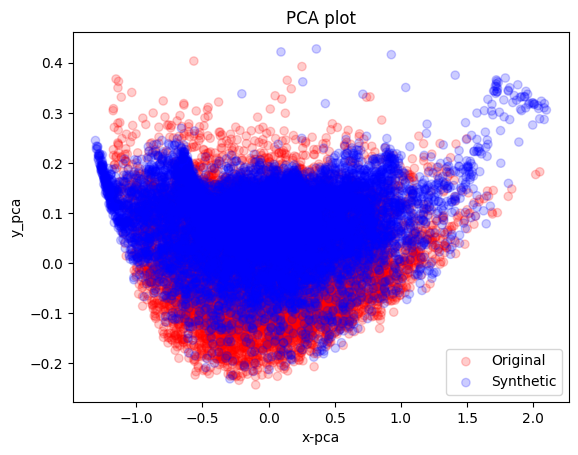

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.000s...
[t-SNE] Computed neighbors for 20000 samples in 0.280s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for sa

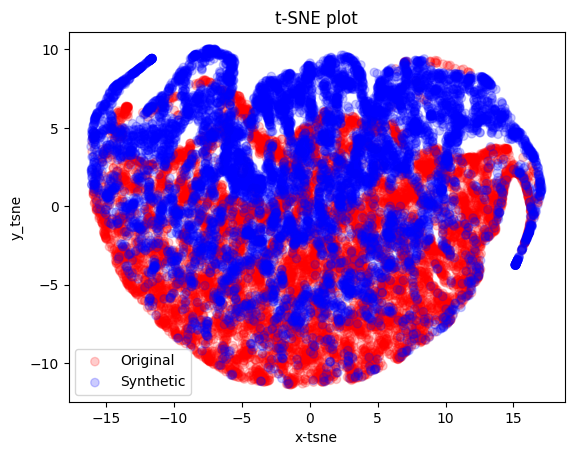

/home/harim/Desktop/pyproject/Project_TS_Generation/utils/metrics.py:93: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(prep_data, hist=False, kde=True, kde_kws={'linewidth': 5}, label='Original', color="red")
/home/harim/Desktop/pyproject/Project_TS_Generation/utils/metrics.py:94: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom

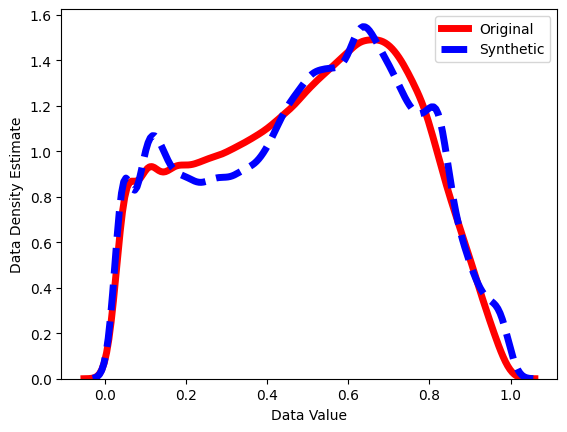

In [8]:
# visualization
visualization(ori_data=ori_data, generated_data=fake_data, analysis='pca', compare=ori_data.shape[0])
visualization(ori_data=ori_data, generated_data=fake_data, analysis='tsne', compare=ori_data.shape[0])
visualization(ori_data=ori_data, generated_data=fake_data, analysis='kernel', compare=ori_data.shape[0])